<a href="https://colab.research.google.com/github/markvasin/Kaggle-Quora-Insincere-Questions-Classification/blob/master/Quora_Question_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Quora Insincere Questions Classification

https://www.kaggle.com/c/quora-insincere-questions-classification

###Packages

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import re

import numpy as np
import pandas as pd
import pickle
import sklearn
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from scipy import sparse
from scipy.sparse import csr_matrix, hstack
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer
from nltk.util import ngrams
from tqdm.autonotebook import tqdm
tqdm.pandas()

In [2]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

###Loading Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
train_path = '/content/drive/My Drive/Colab Notebooks/Advanced Machine Learning/Data/train.csv'
test_path = '/content/drive/My Drive/Colab Notebooks/Advanced Machine Learning/Data/test.csv'

train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

In [5]:
print('Train shape : ', train_df.shape)
print('Test shape : ', test_df.shape)

Train shape :  (1306122, 3)
Test shape :  (375806, 2)


In [6]:
train_df.sample(5)

,qid,question_text,target
718733,8cb41dc361304c6e9e12,"How can Quora learn from Bot Detectives, Dovet...",0
249123,30beacdfa08f290863aa,Why are some people stupid enough to believe t...,0
123108,1818805a6b5344861959,Why does sebaceous cyst grow on scrotum?,0
1047013,cd29e51b9942fad5807a,How can I heal a broken heart from dealing wit...,0
718125,8c95ce37ec1b660d7ad5,What are the ways in which blogs with huge tra...,0


###Preprocessing

* Replacing math equations and url's with common abbrevation.
* Cleaning contractions.
* Spell Correction.
* Removing punctuations.
* Removing Stopwords.
* Using WordNet Lemmatizer

In [0]:
# Replacing math equations and url addresses with tags.
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36
def clean_tag(x):
  if '[math]' in x:
    x = re.sub('\[math\].*?math\]', 'MATH EQUATION', x) #replacing with [MATH EQUATION]
    
  if 'http' in x or 'www' in x:
    x = re.sub('(?:(?:https?|ftp):\/\/)?[\w/\-?=%.]+\.[\w/\-?=%.]+', 'URL', x) #replacing with [url]
  return x

In [0]:
# clean_punct
# https://www.kaggle.com/canming/ensemble-mean-iii-64-36

puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '=', '#', '*', '+', '\\', 
        '•', '~', '@', '£', '·', '_', '{', '}', '©', '^', '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 
        '█', '…', '“', '★', '”', '–', '●', '►', '−', '¢', '¬', '░', '¡', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', 
        '—', '‹', '─', '▒', '：', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '⋅', '‘', '∞', 
        '∙', '）', '↓', '、', '│', '（', '»', '，', '♪', '╩', '╚', '・', '╦', '╣', '╔', '╗', '▬', '❤', '≤', '‡', '√', '◄', '━', 
        '⇒', '▶', '≥', '╝', '♡', '◊', '。', '✈', '≡', '☺', '✔', '↵', '≈', '✓', '♣', '☎', '℃', '◦', '└', '‟', '～', '！', '○', 
        '◆', '№', '♠', '▌', '✿', '▸', '⁄', '□', '❖', '✦', '．', '÷', '｜', '┃', '／', '￥', '╠', '↩', '✭', '▐', '☼', '☻', '┐', 
        '├', '«', '∼', '┌', '℉', '☮', '฿', '≦', '♬', '✧', '〉', '－', '⌂', '✖', '･', '◕', '※', '‖', '◀', '‰', '\x97', '↺', 
        '∆', '┘', '┬', '╬', '،', '⌘', '⊂', '＞', '〈', '⎙', '？', '☠', '⇐', '▫', '∗', '∈', '≠', '♀', '♔', '˚', '℗', '┗', '＊', 
        '┼', '❀', '＆', '∩', '♂', '‿', '∑', '‣', '➜', '┛', '⇓', '☯', '⊖', '☀', '┳', '；', '∇', '⇑', '✰', '◇', '♯', '☞', '´', 
        '↔', '┏', '｡', '◘', '∂', '✌', '♭', '┣', '┴', '┓', '✨', '\xa0', '˜', '❥', '┫', '℠', '✒', '［', '∫', '\x93', '≧', '］', 
        '\x94', '∀', '♛', '\x96', '∨', '◎', '↻', '⇩', '＜', '≫', '✩', '✪', '♕', '؟', '₤', '☛', '╮', '␊', '＋', '┈', '％', 
        '╋', '▽', '⇨', '┻', '⊗', '￡', '।', '▂', '✯', '▇', '＿', '➤', '✞', '＝', '▷', '△', '◙', '▅', '✝', '∧', '␉', '☭', 
        '┊', '╯', '☾', '➔', '∴', '\x92', '▃', '↳', '＾', '׳', '➢', '╭', '➡', '＠', '⊙', '☢', '˝', '∏', '„', '∥', '❝', '☐', 
        '▆', '╱', '⋙', '๏', '☁', '⇔', '▔', '\x91', '➚', '◡', '╰', '\x85', '♢', '˙', '۞', '✘', '✮', '☑', '⋆', 'ⓘ', '❒', 
        '☣', '✉', '⌊', '➠', '∣', '❑', '◢', 'ⓒ', '\x80', '〒', '∕', '▮', '⦿', '✫', '✚', '⋯', '♩', '☂', '❞', '‗', '܂', '☜', 
        '‾', '✜', '╲', '∘', '⟩', '＼', '⟨', '·', '✗', '♚', '∅', 'ⓔ', '◣', '͡', '‛', '❦', '◠', '✄', '❄', '∃', '␣', '≪', '｢', 
        '≅', '◯', '☽', '∎', '｣', '❧', '̅', 'ⓐ', '↘', '⚓', '▣', '˘', '∪', '⇢', '✍', '⊥', '＃', '⎯', '↠', '۩', '☰', '◥', 
        '⊆', '✽', '⚡', '↪', '❁', '☹', '◼', '☃', '◤', '❏', 'ⓢ', '⊱', '➝', '̣', '✡', '∠', '｀', '▴', '┤', '∝', '♏', 'ⓐ', 
        '✎', ';', '␤', '＇', '❣', '✂', '✤', 'ⓞ', '☪', '✴', '⌒', '˛', '♒', '＄', '✶', '▻', 'ⓔ', '◌', '◈', '❚', '❂', '￦', 
        '◉', '╜', '̃', '✱', '╖', '❉', 'ⓡ', '↗', 'ⓣ', '♻', '➽', '׀', '✲', '✬', '☉', '▉', '≒', '☥', '⌐', '♨', '✕', 'ⓝ', 
        '⊰', '❘', '＂', '⇧', '̵', '➪', '▁', '▏', '⊃', 'ⓛ', '‚', '♰', '́', '✏', '⏑', '̶', 'ⓢ', '⩾', '￠', '❍', '≃', '⋰', '♋', 
        '､', '̂', '❋', '✳', 'ⓤ', '╤', '▕', '⌣', '✸', '℮', '⁺', '▨', '╨', 'ⓥ', '♈', '❃', '☝', '✻', '⊇', '≻', '♘', '♞', 
        '◂', '✟', '⌠', '✠', '☚', '✥', '❊', 'ⓒ', '⌈', '❅', 'ⓡ', '♧', 'ⓞ', '▭', '❱', 'ⓣ', '∟', '☕', '♺', '∵', '⍝', 'ⓑ', 
        '✵', '✣', '٭', '♆', 'ⓘ', '∶', '⚜', '◞', '்', '✹', '➥', '↕', '̳', '∷', '✋', '➧', '∋', '̿', 'ͧ', '┅', '⥤', '⬆', '⋱', 
        '☄', '↖', '⋮', '۔', '♌', 'ⓛ', '╕', '♓', '❯', '♍', '▋', '✺', '⭐', '✾', '♊', '➣', '▿', 'ⓑ', '♉', '⏠', '◾', '▹', 
        '⩽', '↦', '╥', '⍵', '⌋', '։', '➨', '∮', '⇥', 'ⓗ', 'ⓓ', '⁻', '⎝', '⌥', '⌉', '◔', '◑', '✼', '♎', '♐', '╪', '⊚', 
        '☒', '⇤', 'ⓜ', '⎠', '◐', '⚠', '╞', '◗', '⎕', 'ⓨ', '☟', 'ⓟ', '♟', '❈', '↬', 'ⓓ', '◻', '♮', '❙', '♤', '∉', '؛', 
        '⁂', 'ⓝ', '־', '♑', '╫', '╓', '╳', '⬅', '☔', '☸', '┄', '╧', '׃', '⎢', '❆', '⋄', '⚫', '̏', '☏', '➞', '͂', '␙', 
        'ⓤ', '◟', '̊', '⚐', '✙', '↙', '̾', '℘', '✷', '⍺', '❌', '⊢', '▵', '✅', 'ⓖ', '☨', '▰', '╡', 'ⓜ', '☤', '∽', '╘', 
        '˹', '↨', '♙', '⬇', '♱', '⌡', '⠀', '╛', '❕', '┉', 'ⓟ', '̀', '♖', 'ⓚ', '┆', '⎜', '◜', '⚾', '⤴', '✇', '╟', '⎛', 
        '☩', '➲', '➟', 'ⓥ', 'ⓗ', '⏝', '◃', '╢', '↯', '✆', '˃', '⍴', '❇', '⚽', '╒', '̸', '♜', '☓', '➳', '⇄', '☬', '⚑', 
        '✐', '⌃', '◅', '▢', '❐', '∊', '☈', '॥', '⎮', '▩', 'ு', '⊹', '‵', '␔', '☊', '➸', '̌', '☿', '⇉', '⊳', '╙', 'ⓦ', 
        '⇣', '｛', '̄', '↝', '⎟', '▍', '❗', '״', '΄', '▞', '◁', '⛄', '⇝', '⎪', '♁', '⇠', '☇', '✊', 'ி', '｝', '⭕', '➘', 
        '⁀', '☙', '❛', '❓', '⟲', '⇀', '≲', 'ⓕ', '⎥', '\u06dd', 'ͤ', '₋', '̱', '̎', '♝', '≳', '▙', '➭', '܀', 'ⓖ', '⇛', '▊', 
        '⇗', '̷', '⇱', '℅', 'ⓧ', '⚛', '̐', '̕', '⇌', '␀', '≌', 'ⓦ', '⊤', '̓', '☦', 'ⓕ', '▜', '➙', 'ⓨ', '⌨', '◮', '☷', 
        '◍', 'ⓚ', '≔', '⏩', '⍳', '℞', '┋', '˻', '▚', '≺', 'ْ', '▟', '➻', '̪', '⏪', '̉', '⎞', '┇', '⍟', '⇪', '▎', '⇦', '␝', 
        '⤷', '≖', '⟶', '♗', '̴', '♄', 'ͨ', '̈', '❜', '̡', '▛', '✁', '➩', 'ா', '˂', '↥', '⏎', '⎷', '̲', '➖', '↲', '⩵', '̗', '❢', 
        '≎', '⚔', '⇇', '̑', '⊿', '̖', '☍', '➹', '⥊', '⁁', '✢']

def clean_punct(x):
  x = str(x)
  for punct in puncts:
    if punct in x:
      x = x.replace(punct, ' ')
    return x

In [0]:
# correct_mispell
# https://www.kaggle.com/oysiyl/107-place-solution-using-public-kernel

mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater', 'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'bitcoin', 'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend', 'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization', 'demonetisation': 'demonetization', 
                'electroneum':'bitcoin','nanodegree':'degree','hotstar':'star','dream11':'dream','ftre':'fire','tensorflow':'framework','unocoin':'bitcoin',
                'lnmiit':'limit','unacademy':'academy','altcoin':'bitcoin','altcoins':'bitcoin','litecoin':'bitcoin','coinbase':'bitcoin','cryptocurency':'cryptocurrency',
                'simpliv':'simple','quoras':'quora','schizoids':'psychopath','remainers':'remainder','twinflame':'soulmate','quorans':'quora','brexit':'demonetized',
                'iiest':'institute','dceu':'comics','pessat':'exam','uceed':'college','bhakts':'devotee','boruto':'anime',
                'cryptocoin':'bitcoin','blockchains':'blockchain','fiancee':'fiance','redmi':'smartphone','oneplus':'smartphone','qoura':'quora','deepmind':'framework','ryzen':'cpu','whattsapp':'whatsapp',
                'undertale':'adventure','zenfone':'smartphone','cryptocurencies':'cryptocurrencies','koinex':'bitcoin','zebpay':'bitcoin','binance':'bitcoin','whtsapp':'whatsapp',
                'reactjs':'framework','bittrex':'bitcoin','bitconnect':'bitcoin','bitfinex':'bitcoin','yourquote':'your quote','whyis':'why is','jiophone':'smartphone',
                'dogecoin':'bitcoin','onecoin':'bitcoin','poloniex':'bitcoin','7700k':'cpu','angular2':'framework','segwit2x':'bitcoin','hashflare':'bitcoin','940mx':'gpu',
                'openai':'framework','hashflare':'bitcoin','1050ti':'gpu','nearbuy':'near buy','freebitco':'bitcoin','antminer':'bitcoin','filecoin':'bitcoin','whatapp':'whatsapp',
                'empowr':'empower','1080ti':'gpu','crytocurrency':'cryptocurrency','8700k':'cpu','whatsaap':'whatsapp','g4560':'cpu','payymoney':'pay money',
                'fuckboys':'fuck boys','intenship':'internship','zcash':'bitcoin','demonatisation':'demonetization','narcicist':'narcissist','mastuburation':'masturbation',
                'trignometric':'trigonometric','cryptocurreny':'cryptocurrency','howdid':'how did','crytocurrencies':'cryptocurrencies','phycopath':'psychopath',
                'bytecoin':'bitcoin','possesiveness':'possessiveness','scollege':'college','humanties':'humanities','altacoin':'bitcoin','demonitised':'demonetized',
                'brasília':'brazilia','accolite':'accolyte','econimics':'economics','varrier':'warrier','quroa':'quora','statergy':'strategy','langague':'language',
                'splatoon':'game','7600k':'cpu','gate2018':'gate 2018','in2018':'in 2018','narcassist':'narcissist','jiocoin':'bitcoin','hnlu':'hulu','7300hq':'cpu',
                'weatern':'western','interledger':'blockchain','deplation':'deflation', 'cryptocurrencies':'cryptocurrency', 'bitcoin':'blockchain cryptocurrency',}

def correct_mispell(x):
  words = x.split()
  for i in range(0, len(words)):
    if mispell_dict.get(words[i]) is not None:
      words[i] = mispell_dict.get(words[i])
    elif mispell_dict.get(words[i].lower()) is not None:
      words[i] = mispell_dict.get(words[i].lower())
        
  words = " ".join(words)
  return words

In [0]:
# remove stopwords
def remove_stopwords(x):
  x = [word for word in x.split() if word not in STOPWORDS]
  x = ' '.join(x)

  return x

In [0]:
# clean word contractions
## https://www.kaggle.com/theoviel/improve-your-score-with-text-preprocessing-v2 

contraction_mapping = {"We'd": "We had", "That'd": "That had", "AREN'T": "Are not", "HADN'T": "Had not", "Could've": "Could have", "LeT's": "Let us", "How'll": "How will", "They'll": "They will", "DOESN'T": "Does not", "HE'S": "He has", "O'Clock": "Of the clock", "Who'll": "Who will", "What'S": "What is", "Ain't": "Am not", "WEREN'T": "Were not", "Y'all": "You all", "Y'ALL": "You all", "Here's": "Here is", "It'd": "It had", "Should've": "Should have", "I'M": "I am", "ISN'T": "Is not", "Would've": "Would have", "He'll": "He will", "DON'T": "Do not", "She'd": "She had", "WOULDN'T": "Would not", "She'll": "She will", "IT's": "It is", "There'd": "There had", "It'll": "It will", "You'll": "You will", "He'd": "He had", "What'll": "What will", "Ma'am": "Madam", "CAN'T": "Can not", "THAT'S": "That is", "You've": "You have", "She's": "She is", "Weren't": "Were not", "They've": "They have", "Couldn't": "Could not", "When's": "When is", "Haven't": "Have not", "We'll": "We will", "That's": "That is", "We're": "We are", "They're": "They' are", "You'd": "You would", "How'd": "How did", "What're": "What are", "Hasn't": "Has not", "Wasn't": "Was not", "Won't": "Will not", "There's": "There is", "Didn't": "Did not", "Doesn't": "Does not", "You're": "You are", "He's": "He is", "SO's": "So is", "We've": "We have", "Who's": "Who is", "Wouldn't": "Would not", "Why's": "Why is", "WHO's": "Who is", "Let's": "Let us", "How's": "How is", "Can't": "Can not", "Where's": "Where is", "They'd": "They had", "Don't": "Do not", "Shouldn't":"Should not", "Aren't":"Are not", "ain't": "is not", "What's": "What is", "It's": "It is", "Isn't":"Is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have" }

def clean_contractions(text):
    specials = ["’", "‘", "´", "`"]
    for s in specials:
        text = text.replace(s, "'")
    
    text = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in text.split(" ")])
    return text

In [0]:
# word lemmatizing

lemmatizer = WordNetLemmatizer()
def lemma_text(x):
  x = x.split()
  x = [lemmatizer.lemmatize(word) for word in x]
  x = ' '.join(x)

  return x

In [0]:
def data_cleaning(x):
  x = clean_tag(x)
  x = clean_punct(x)
  x = correct_mispell(x)
  x = remove_stopwords(x)
  x = clean_contractions(x)
  x = lemma_text(x)
  return x

In [16]:
train_df['preprocessed_question_text'] = train_df['question_text'].progress_map(lambda x: data_cleaning(x))
test_df['preprocessed_question_text'] = test_df['question_text'].progress_map(lambda x: data_cleaning(x))

In [18]:
train_df.sample(5)

,qid,question_text,target,preprocessed_question_text
487004,5f5f5cec89cf3e7d8074,Why do Tamilian's always in need for water?,1,Why Tamilian's always need water?
837692,a4293f92cdf9dea520ef,What is use of static members in Java?,0,What use static member Java?
256637,323ca2df021f6cb1673d,Is it illegal to destroy private lock on publi...,0,Is illegal destroy private lock public bicycles?
1171059,e57eac04854dceba7296,What are some of the best ways to become extre...,0,What best way become extremely successful with...
238982,2ebf80944f10541e8d52,How can I score exemption in IPCC auditing?,0,How I score exemption IPCC auditing?


###Train, Validation and Test Data Split

In [19]:
y = train_df['target']
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=2020)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2020)

# drop the target column in X
X_train = X_train.drop(columns=['target'])
X_val = X_val.drop(columns=['target'])
X_test = X_test.drop(columns=['target'])

print('X_train: ', X_train.shape, y_train.shape)
print('X_test: ', X_test.shape, y_test.shape)
print('X_val: ', X_val.shape, y_val.shape)

X_train:  (940407, 3) (940407,)
X_test:  (261225, 3) (261225,)
X_val:  (104490, 3) (104490,)


### Baseline Models

In [0]:
def threshold_search(true_y, pred_y):
  best_score = 0.0
  best_threshold = 0.0
  for thresh in np.arange(0.15, 0.25, 0.01):
      thresh = np.round(thresh, 2)
      score = f1_score(true_y, (pred_y > thresh))
      if score > best_score:
        best_score = score
        best_threshold = thresh
      print("F1 score at threshold {0} is {1}".format(thresh, score))
  
  print('Best threshold is', best_threshold)
  return best_threshold

In [0]:
def plot_confusion_matrix(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)
  plt.figure(figsize=(5, 3))
  sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
  # plt.title('Confusion Matrix')
  plt.show()
  
  print(f"Correctly classified sincere questions: {round(cm[0][0]/(cm[0][0] + cm[0][1])*100, 2)}%")
  print(f"Correctly classified insincere questions: {round(cm[1][1]/(cm[1][0] + cm[1][1])*100, 2)}%")

####Preparing Features

Bag of Words

In [0]:
tf_vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,3), min_df=3, max_df=0.9, max_features=50000)
tf_vectorizer.fit(pd.concat([train_df['preprocessed_question_text'], test_df['preprocessed_question_text']]))

X_train_BOW = tf_vectorizer.transform(X_train['preprocessed_question_text'])
X_val_BOW = tf_vectorizer.transform(X_val['preprocessed_question_text'])
X_test_BOW = tf_vectorizer.transform(X_test['preprocessed_question_text'])

TF-IDF

In [0]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,3), min_df=3, max_df=0.9, max_features=50000)
tfidf_vectorizer.fit(pd.concat([train_df['preprocessed_question_text'], test_df['preprocessed_question_text']]))

X_train_TFIDF = tfidf_vectorizer.transform(X_train['preprocessed_question_text'])
X_val_TFIDF = tfidf_vectorizer.transform(X_val['preprocessed_question_text'])
X_test_TFIDF = tfidf_vectorizer.transform(X_test['preprocessed_question_text'])

####Logistic Regression with Bag of Words

Using grid search to tune hyperparameters

In [0]:
params = {'C': [0.001, 0.001, 0.1, 1, 10]}

gridsearch = GridSearchCV(LogisticRegression(), params, scoring='f1', n_jobs=-1, verbose=1)
gridsearch.fit(X_train_BOW, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'C': [0.001, 0.001, 0.1, 1, 10]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='f1', verbose=1)

In [0]:
gridsearch.best_params_

{'C': 10}

Train the model using best hyperparameter

In [0]:
model = LogisticRegression(**gridsearch.best_params_)
model.fit(X_train_BOW, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Find the best decision threshold using validation set

In [0]:
pred_prob_val = model.predict_proba(X_val_BOW)[:,1]
threshold = threshold_search(y_val, pred_prob_val)

F1 score at threshold 0.15 is 0.5769713711702662
F1 score at threshold 0.16 is 0.5810248864436057
F1 score at threshold 0.17 is 0.5835505735140772
F1 score at threshold 0.18 is 0.583837712005321
F1 score at threshold 0.19 is 0.5841162554917201
F1 score at threshold 0.2 is 0.5843683524325808
F1 score at threshold 0.21 is 0.5832114245907349
F1 score at threshold 0.22 is 0.5827561837455831
F1 score at threshold 0.23 is 0.582003006657599
F1 score at threshold 0.24 is 0.5827843335987837
Best threshold is 0.2


Make prediction on the test set

F1 score from the test set is 0.574886369859263


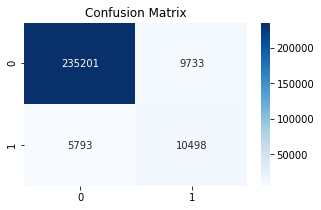

Correctly classified sincere questions: 96.03%
Correctly classified insincere questions: 64.44%


In [0]:
pred_prob_test = model.predict_proba(X_test_BOW)[:,1]
pred_test = pred_prob_test > threshold
print('F1 score from the test set is', f1_score(y_test, pred_test))
plot_confusion_matrix(y_test, pred_test)

In [0]:
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97    244934
           1       0.52      0.64      0.57     16291

    accuracy                           0.94    261225
   macro avg       0.75      0.80      0.77    261225
weighted avg       0.95      0.94      0.94    261225



####Logistic Regression with TF-IDF features
Using grid search to tune hyperparameters

In [0]:
parmas = {'C': [0.001, 0.001, 0.1, 1, 10]}

gridsearch = GridSearchCV(LogisticRegression(), parmas, scoring='f1', n_jobs=-1, verbose=1)
gridsearch.fit(X_train_TFIDF, y_train)
gridsearch.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   58.4s finished


{'C': 10}

In [0]:
model = LogisticRegression(**gridsearch.best_params_)
model.fit(X_train_TFIDF, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
pred_prob_val = model.predict_proba(X_val_TFIDF)[:,1]
threshold = threshold_search(y_val, pred_prob_val)

F1 score at threshold 0.15 is 0.5858609841514809
F1 score at threshold 0.16 is 0.5892065804650033
F1 score at threshold 0.17 is 0.5914585012087027
F1 score at threshold 0.18 is 0.5954565588812251
F1 score at threshold 0.19 is 0.598542029546481
F1 score at threshold 0.2 is 0.599763406940063
F1 score at threshold 0.21 is 0.6016847172081828
F1 score at threshold 0.22 is 0.6030798453293534
F1 score at threshold 0.23 is 0.604423620202577
F1 score at threshold 0.24 is 0.6042350967922286
Best threshold is 0.23


F1 score from the test set is 0.5922391682065142


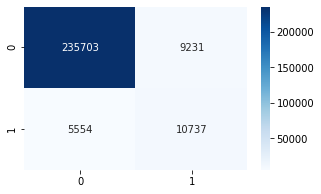

Correctly classified sincere questions: 96.23%
Correctly classified insincere questions: 65.91%


In [0]:
pred_prob_test = model.predict_proba(X_test_TFIDF)[:,1]
pred_test = pred_prob_test > threshold
print('F1 score from the test set is', f1_score(y_test, pred_test))
plot_confusion_matrix(y_test, pred_test)

###Deep Learning Models

####Word Embeddings

In [0]:
from os.path import exists
if not exists('glove.840B.300d.zip'):
  !wget -O glove.840B.300d.zip http://nlp.stanford.edu/data/glove.840B.300d.zip
  !unzip glove.840B.300d.zip

In [0]:
def load_glove(word_index):
    EMBEDDING_FILE = './glove.840B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))

    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = all_embs.mean(), all_embs.std()
    embed_size = all_embs.shape[1]

    # word_index = tokenizer.word_index
    nb_words = min(max_features, len(word_index))
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: embedding_matrix[i] = embedding_vector
            
    return embedding_matrix 

####Bidirectional LSTM with Attention Mechanism

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torchtext import data

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

embedding_size = 300
max_features = 120000
max_length = 72
batch_size = 1000

In [0]:
class Attention(nn.Module):
    def __init__(self, feature_dim, step_dim, bias=True, **kwargs):
        super(Attention, self).__init__(**kwargs)
        
        self.supports_masking = True

        self.bias = bias
        self.feature_dim = feature_dim
        self.step_dim = step_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
        if bias:
            self.b = nn.Parameter(torch.zeros(step_dim))
        
    def forward(self, x, mask=None):
        feature_dim = self.feature_dim
        step_dim = self.step_dim

        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        if self.bias:
            eij = eij + self.b
            
        eij = torch.tanh(eij)
        a = torch.exp(eij)
        
        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)

In [0]:
class NeuralNet(nn.Module):
    def __init__(self, embedding_matrix):
        super(NeuralNet, self).__init__()
        
        hidden_size = 128
        
        self.embedding = nn.Embedding(max_features, embedding_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        
        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(embedding_size, hidden_size, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(hidden_size*2, hidden_size, bidirectional=True, batch_first=True)
        
        self.lstm_attention = Attention(hidden_size*2, max_length)
        self.gru_attention = Attention(hidden_size*2, max_length)
        
        self.linear = nn.Linear(1024, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(16, 1)
        
    def forward(self, x):
        h_embedding = self.embedding(x)
        h_embedding = torch.squeeze(self.embedding_dropout(torch.unsqueeze(h_embedding, 0)))
        
        h_lstm, _ = self.lstm(h_embedding)
        h_gru, _ = self.gru(h_lstm)
        
        h_lstm_atten = self.lstm_attention(h_lstm)
        h_gru_atten = self.gru_attention(h_gru)
        
        avg_pool = torch.mean(h_gru, 1)
        max_pool, _ = torch.max(h_gru, 1)
        
        conc = torch.cat((h_lstm_atten, h_gru_atten, avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        
        return out

In [0]:
train_X = X_train["question_text"].fillna("_##_").values
val_X = X_val["question_text"].fillna("_##_").values
test_X = X_test["question_text"].fillna("_##_").values


tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_X))
train_X = tokenizer.texts_to_sequences(train_X)
val_X = tokenizer.texts_to_sequences(val_X)
test_X = tokenizer.texts_to_sequences(test_X)

train_X = pad_sequences(train_X, maxlen=max_length)
val_X = pad_sequences(val_X, maxlen=max_length)
test_X = pad_sequences(test_X, maxlen=max_length)

train_y = y_train.values
val_y = y_val.values
test_y = y_test.values

In [0]:
embedding_matrix = load_glove(tokenizer.word_index)

In [0]:
x_train = torch.tensor(train_X, dtype=torch.long).cuda()
y_train = torch.tensor(train_y, dtype=torch.float32).unsqueeze(-1).cuda()

x_val = torch.tensor(val_X, dtype=torch.long).cuda()
y_val = torch.tensor(val_y, dtype=torch.float32).unsqueeze(-1).cuda()

train_dataset = TensorDataset(x_train, y_train)
val_dataset = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)   

In [0]:
model = NeuralNet(embedding_matrix)
model.cuda()

NeuralNet(
  (embedding): Embedding(120000, 300)
  (embedding_dropout): Dropout2d(p=0.1, inplace=False)
  (lstm): LSTM(300, 128, batch_first=True, bidirectional=True)
  (gru): GRU(256, 128, batch_first=True, bidirectional=True)
  (lstm_attention): Attention()
  (gru_attention): Attention()
  (linear): Linear(in_features=1024, out_features=16, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.1, inplace=False)
  (out): Linear(in_features=16, out_features=1, bias=True)
)

In [0]:
train_epochs = 10

loss_fn = torch.nn.BCEWithLogitsLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters())


for epoch in range(train_epochs):
    model.train()
    with tqdm(total=len(train_loader), desc='train') as t:
      epoch_loss = 0
      for i, (x_batch, y_batch) in enumerate(train_loader):
          y_pred = model(x_batch)
          loss = loss_fn(y_pred, y_batch)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          epoch_loss = (epoch_loss*i + loss.item()) / (i+1)
          
          t.set_postfix(loss='{:05.3f}'.format(epoch_loss))
          t.update()
    
    model.eval()
    with tqdm(total=len(valid_loader), desc='val') as t:
      with torch.no_grad():
        epoch_loss = 0
        for i, (x_batch, y_batch) in enumerate(valid_loader):
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            epoch_loss = (epoch_loss*i + loss.item()) / (i+1)
            
            t.set_postfix(loss='{:05.3f}'.format(epoch_loss))
            t.update()

In [0]:
x_test = torch.tensor(test_X, dtype=torch.long).cuda()
y_test = torch.tensor(test_y, dtype=torch.float32).unsqueeze(-1).cuda()

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

prediction_list = []

with torch.no_grad():
  for i, (x_batch, y_batch) in enumerate(test_loader):
      y_pred = model(x_batch)
      prediction_list.append(torch.nn.functional.sigmoid(y_pred).cpu().numpy()[:, 0].tolist())

y_predict = np.array([j for sub in prediction_list for j in sub])

In [0]:
def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)]):
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

In [0]:
threshold_search(test_y, y_predict)

{'f1': 0.6741396263520157, 'threshold': 0.37}

####Using BERT Transformers

In [0]:
try: 
    from simpletransformers.classification import ClassificationModel
except:
    !pip install simpletransformers

In [0]:
train_data = train_df[['question_text','target']]
train_data.columns =['text', 'labels']
train_data, test_data = train_test_split(train_data, test_size=0.1, random_state=2020)
train_data.head()

,text,labels
1037760,Are Scandinavians better looking or in general...,1
1093087,Can GATE really change one's life from 3 tier ...,0
746003,Does anorexia make scoliosis look good?,0
1160112,What is the criteria used for an answer to inc...,0
602530,Why Muslims hate homosexuals?,1


In [0]:
model_args = {
    "num_train_epochs": 1,
    "fp16": False,
    "overwrite_output_dir": True
}
model = ClassificationModel('roberta', 'distilroberta-base', args=model_args)
model.train_model(train_data, acc=sklearn.metrics.f1_score)

In [0]:
result, model_outputs, wrong_predictions = model.eval_model(test_data, acc=sklearn.metrics.f1_score)